Importing Libraries

In [24]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [46]:
root_dir = 'data'
annotations_file = 'data/annotations.txt'

Creating the Dataset

In [47]:
class CarDataset(Dataset):
    def __init__(self, root_dir, annotations_file, sequence_length=5, transform=None):
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.annotations = np.loadtxt(annotations_file, delimiter=',')
        self.image_files = [os.path.join(self.root_dir, f'{index + 1:08}.jpg') for index in range(len(self.annotations))]

    def __len__(self):
        return len(self.annotations) - self.sequence_length + 1

    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        
        images = []
        labels = []
        for i in range(idx, idx_end):
            image_name = self.image_files[i]
            image = cv2.imread(image_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_size = image.shape[:2][::-1]  # (width, height)
            
            # Resize and transform image
            if self.transform:
                image = self.transform(image)
            
            images.append(image)
            
            # Resize labels (bounding boxes) to match the transformed image size
            label = self.annotations[i].copy()
            label = self.resize_bbox(label, original_size, (224, 224))
            labels.append(label)
        
        labels = np.array(labels)
        return torch.stack(images), torch.tensor(labels, dtype=torch.float32)
    
    def resize_bbox(self, labels, original_size, new_size):
        # calculate scale factors
        scale_x = new_size[0] / original_size[0]
        scale_y = new_size[1] / original_size[1]
            
        # scale labels
        labels[0] *= scale_x  # xmin
        labels[1] *= scale_y  # ymin
        labels[2] *= scale_x  # xmax
        labels[3] *= scale_y  # ymax

        for i in range(len(labels)):
            labels[i] = labels[i]/224
        
        return labels



#ttransform including resizing and normalization for VGG
vgg_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CarDataset(root_dir,annotations_file,transform=vgg_transform)
images, labels = dataset[0]
print(images.size())
print(labels.size())

torch.Size([5, 3, 224, 224])
torch.Size([5, 4])


tensor([ 29.7500, 107.8824, 108.8500, 189.4118])


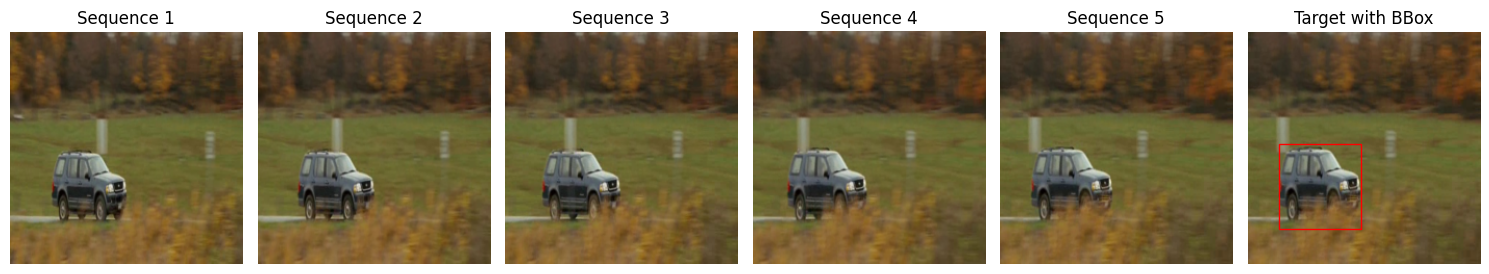

In [27]:
def plot_sequence_with_bbox(dataset, idx):

    images, bbox = dataset[idx]
    
    fig, axs = plt.subplots(1, len(images) + 1, figsize=(15, 5))
    
    # loop through all images in the sequence
    for i, image in enumerate(images):
        image_np = image.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean  # Denormalize
        image_np = np.clip(image_np, 0, 1)  # clip values to be btw 0 and 1
        
        axs[i].imshow(image_np)
        axs[i].set_title(f'Sequence {i+1}')
        axs[i].axis('off')

    # process the final image in the sequence for bounding box overlay
    image_np = images[-1].numpy().transpose(1, 2, 0)
    image_np = std * image_np + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)  # clip values to be btw 0 and 1
    bbox = bbox[-1]
    bbox = bbox*224
    print(bbox)
    
    # display the last image with the bounding box
    axs[-1].imshow(image_np)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    axs[-1].add_patch(rect)
    axs[-1].set_title('Target with BBox')
    axs[-1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sequence_with_bbox(dataset, 200)


Model Architecture: ConvLSTM

In [18]:
class ConvLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.vgg_backbone = models.vgg16(weights=True).features
        for param in self.vgg_backbone.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(input_size=(512*7*7) + 4, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)  # output 4 for bounding box

    def forward(self, images, bboxes):
        batch_size, sequence_length, C, H, W = images.size()
        images = images.reshape(batch_size * sequence_length, C, H, W)
        features = self.vgg_backbone(images)
        features = features.view(batch_size, sequence_length, -1)

        placeholder_bbox = torch.zeros(batch_size, 1, 4, device=images.device)
        bboxes_with_placeholder = torch.cat((bboxes, placeholder_bbox), dim=1)

        combined_input = torch.cat((features[:, :-1, :], bboxes_with_placeholder[:, :-1, :]), dim=2)
        lstm_out, _ = self.lstm(combined_input)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions


Train-Test Splits and DataLoaders

In [28]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% of the dataset for training
test_size = dataset_size - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Training Loop

Using device: cuda
Epoch 1, Train Loss: 0.10379185827448964, Test Loss: 0.03493419699370861
Epoch 2, Train Loss: 0.037320410348474976, Test Loss: 0.05725850388407707
Epoch 3, Train Loss: 0.03295101480558515, Test Loss: 0.0373712582141161
Epoch 4, Train Loss: 0.030698876157402993, Test Loss: 0.0421551913022995
Epoch 5, Train Loss: 0.029117638487368824, Test Loss: 0.024326471611857414
Epoch 6, Train Loss: 0.021076727439649404, Test Loss: 0.023540401235222816
Epoch 7, Train Loss: 0.02383458479307592, Test Loss: 0.022100177258253098
Epoch 8, Train Loss: 0.021446215328760444, Test Loss: 0.036956840604543684
Epoch 9, Train Loss: 0.01818361448124051, Test Loss: 0.02087309576570988
Epoch 10, Train Loss: 0.020955435167998075, Test Loss: 0.01947776649147272
Epoch 11, Train Loss: 0.01706816567108035, Test Loss: 0.01402499184012413
Epoch 12, Train Loss: 0.015821500029414893, Test Loss: 0.014566862136125564
Epoch 13, Train Loss: 0.015720124947838487, Test Loss: 0.016085332706570626
Epoch 14, Train 

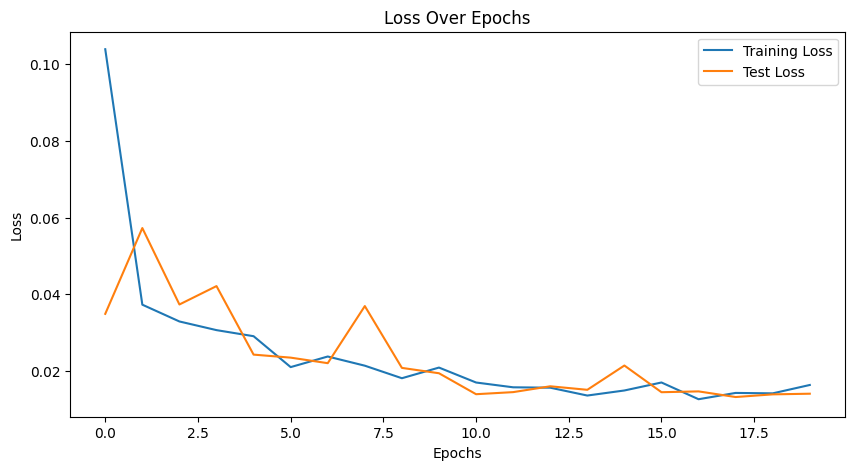

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ConvLSTM(hidden_size=256, num_layers=4).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  # No need to explicitly move this to the device

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


train_losses = []
test_losses = []


# training loop :)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    for images, bboxes in train_loader:

        inputs, targets = images.to(device), bboxes[:, -1, :].to(device)
        bboxes_input = bboxes[:, :-1, :].to(device)  # bboxes for first 4 imgs

        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs, bboxes_input)
        loss = criterion(outputs, targets)

        # backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # evaluation phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, bboxes in test_loader:
            
            inputs, targets = images.to(device), bboxes[:, -1, :].to(device)
            bboxes_input = bboxes[:, :-1, :].to(device)

            # forward pass
            outputs = model(inputs, bboxes_input)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


In [31]:
model_path = 'weights/model.pth'

# save the model state dictionary
torch.save(model.state_dict(), model_path)

Visualizing Results

In [48]:
def plot_sequence_with_pred_and_actual_bbox(dataset, idx, pred_bbox):

    images, actual_bbox = dataset[idx]
    pred_bbox = pred_bbox.detach().cpu().numpy()  # Assuming prediction is on GPU and needs to be moved to CPU

    fig, axs = plt.subplots(1, len(images) + 1, figsize=(15, 5))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # plot each image in the sequence
    for i, image in enumerate(images):
        image_np = image.numpy().transpose(1, 2, 0)
        image_np = std * image_np + mean  # Denormalize
        image_np = np.clip(image_np, 0, 1)  # Clip values

        axs[i].imshow(image_np)
        axs[i].set_title(f'Sequence {i+1}')
        axs[i].axis('off')

    # plot the last image with actual and predicted bounding boxes
    image_np = images[-1].numpy().transpose(1, 2, 0)
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    actual_bbox_scaled = actual_bbox[-1].numpy() * 224 # reescaling back to vgg dims
    pred_bbox_scaled = pred_bbox * 224

    axs[-1].imshow(image_np)
    # actual bbox in red
    rect_actual = patches.Rectangle((actual_bbox_scaled[0], actual_bbox_scaled[1]), 
                                    actual_bbox_scaled[2] - actual_bbox_scaled[0], 
                                    actual_bbox_scaled[3] - actual_bbox_scaled[1], 
                                    linewidth=2, edgecolor='r', facecolor='none', label='Actual')
    # predicted bbox in blue
    rect_pred = patches.Rectangle((pred_bbox_scaled[0], pred_bbox_scaled[1]), 
                                  pred_bbox_scaled[2] - pred_bbox_scaled[0], 
                                  pred_bbox_scaled[3] - pred_bbox_scaled[1], 
                                  linewidth=2, edgecolor='b', facecolor='none', label='Predicted')
    axs[-1].add_patch(rect_actual)
    axs[-1].add_patch(rect_pred)
    axs[-1].set_title('Last Image with Actual (Red) & Predicted (Blue) BBox')
    axs[-1].axis('off')

    fig.legend(handles=[rect_actual, rect_pred], loc='upper right')
    plt.tight_layout()
    plt.show()

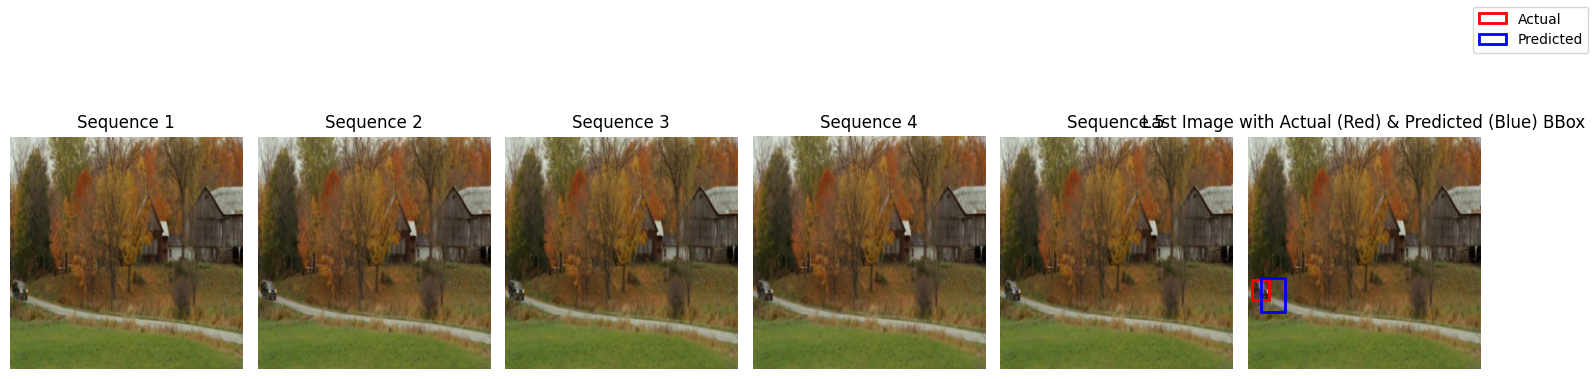

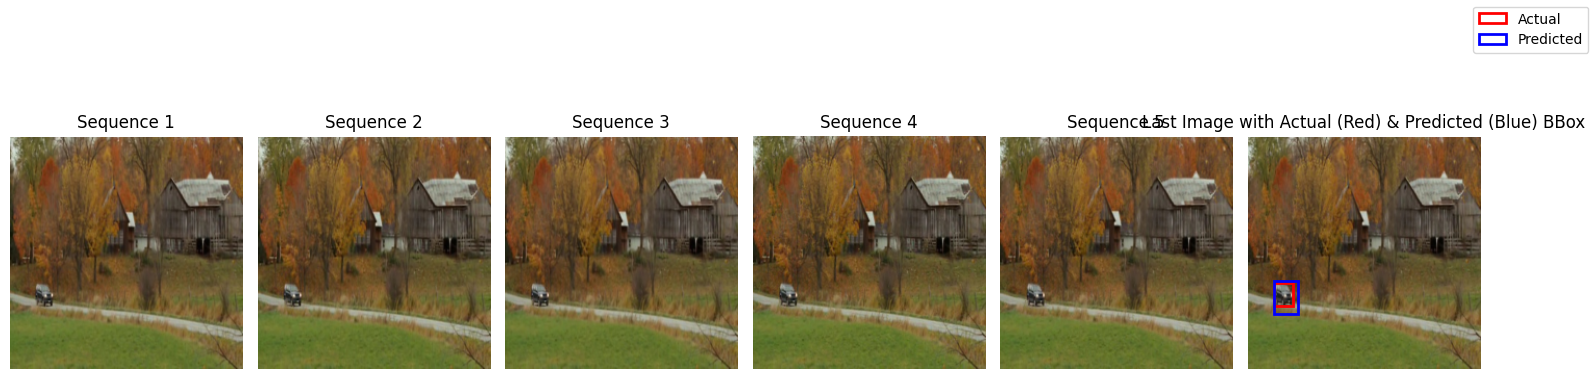

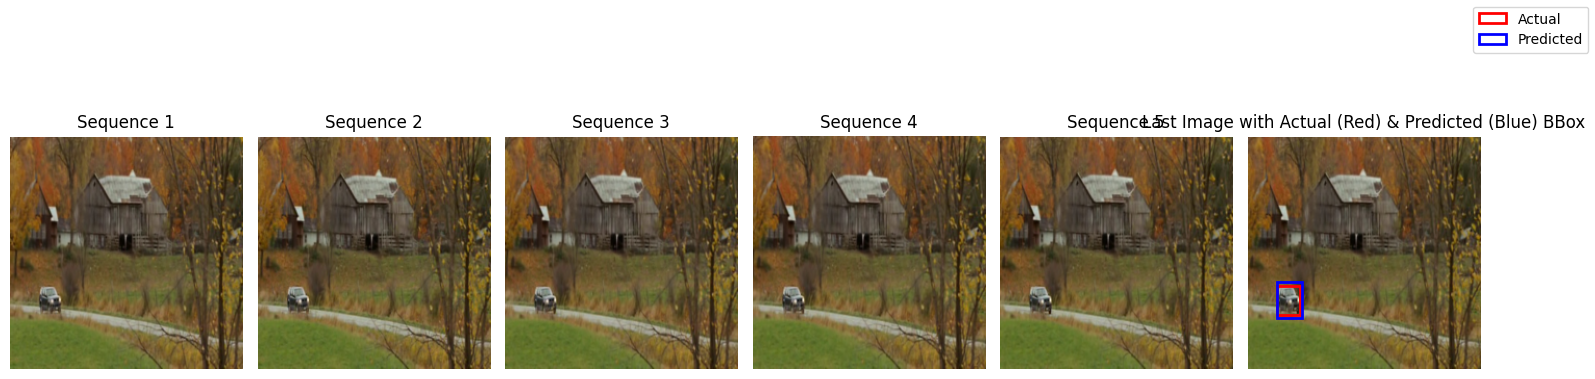

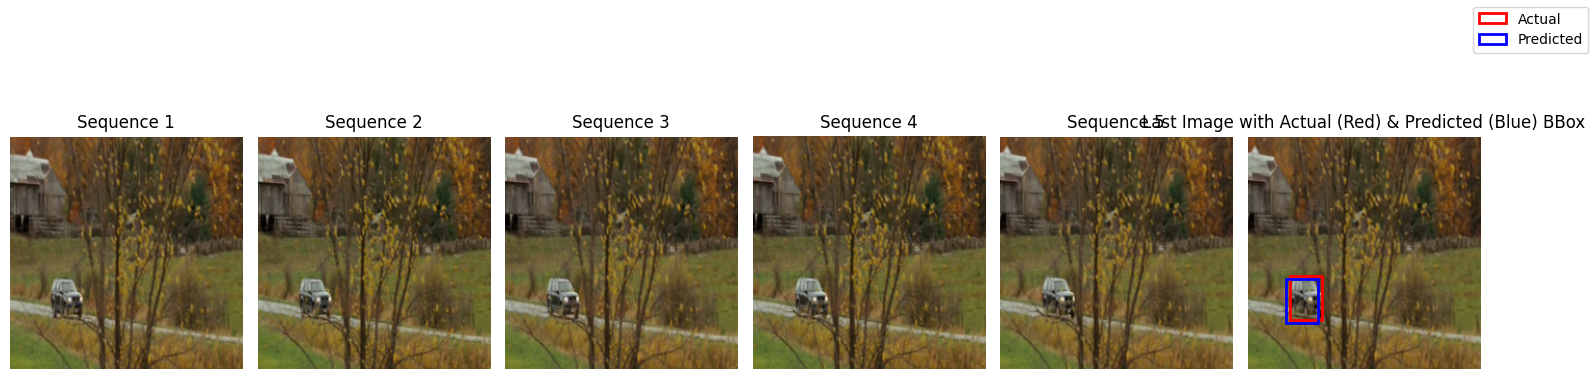

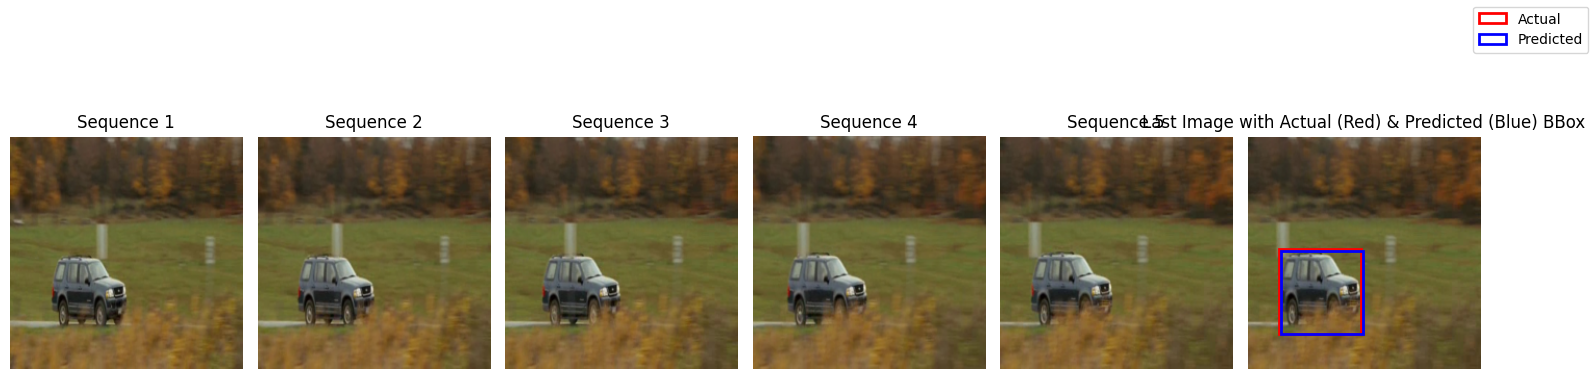

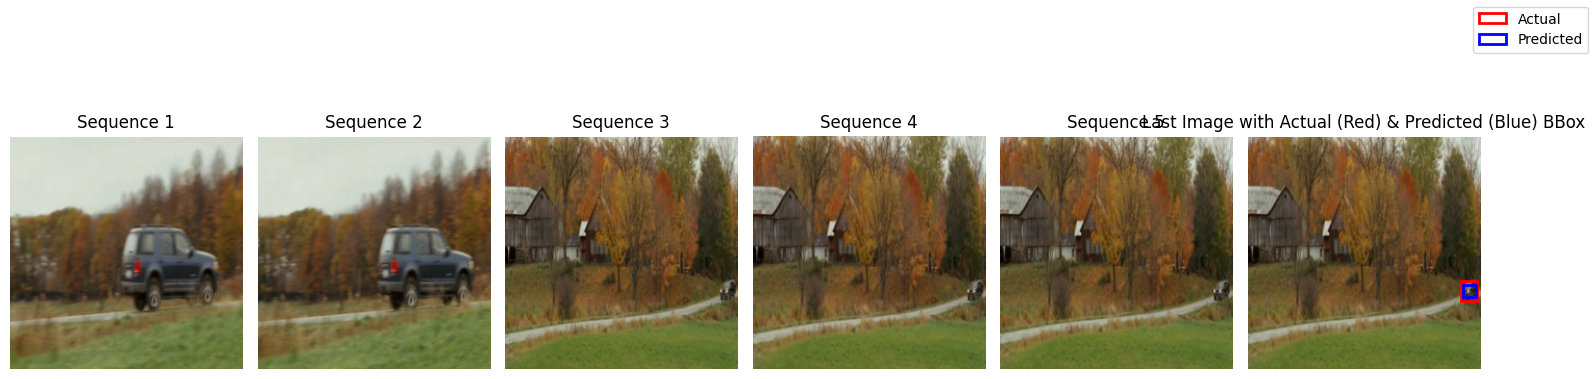

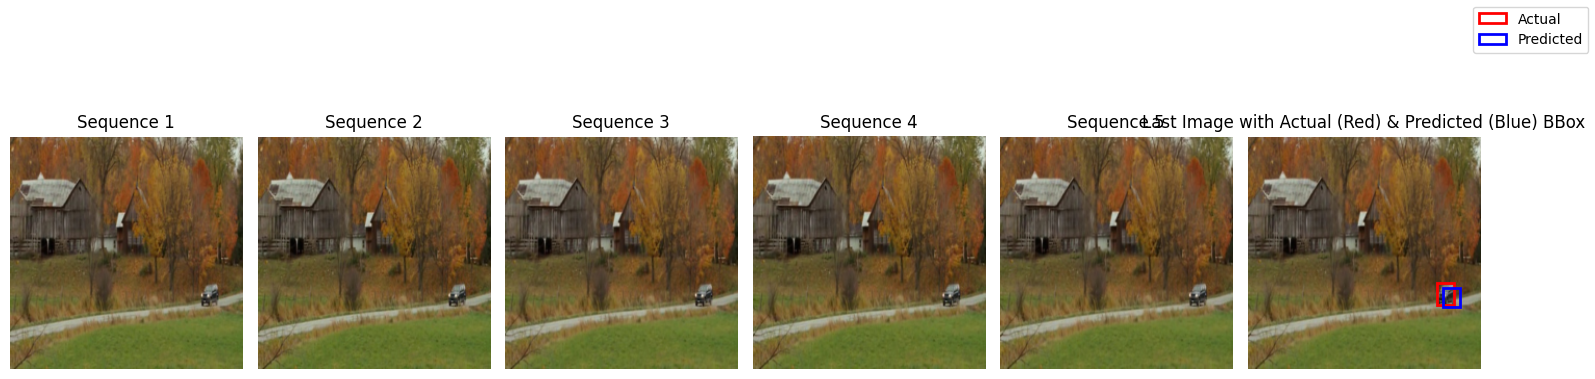

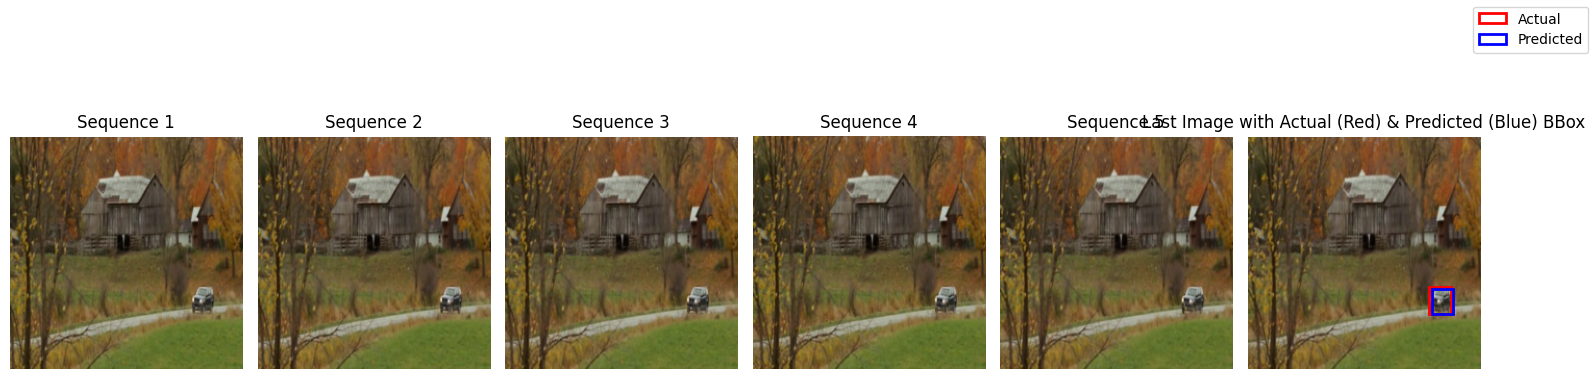

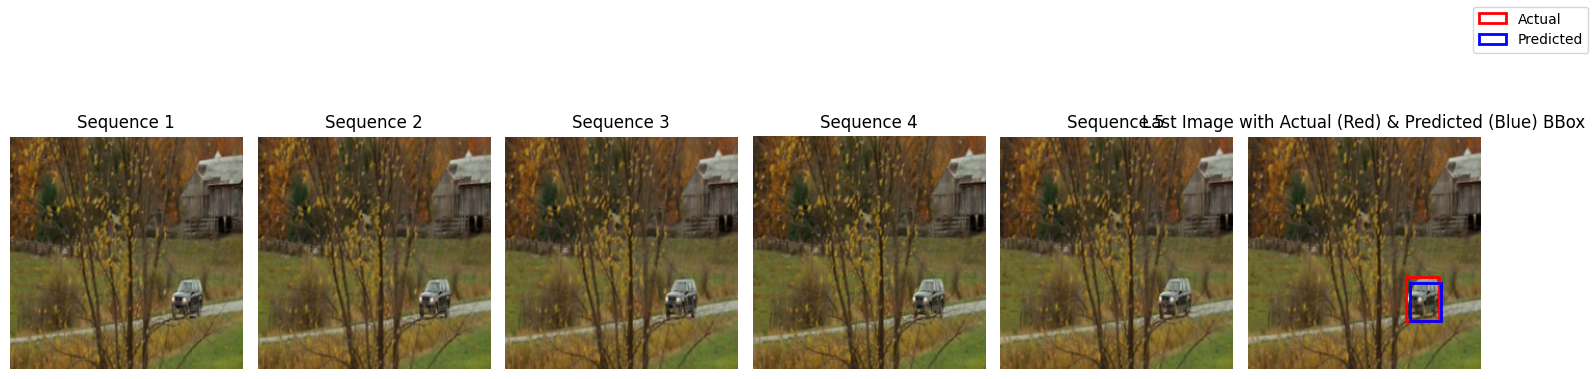

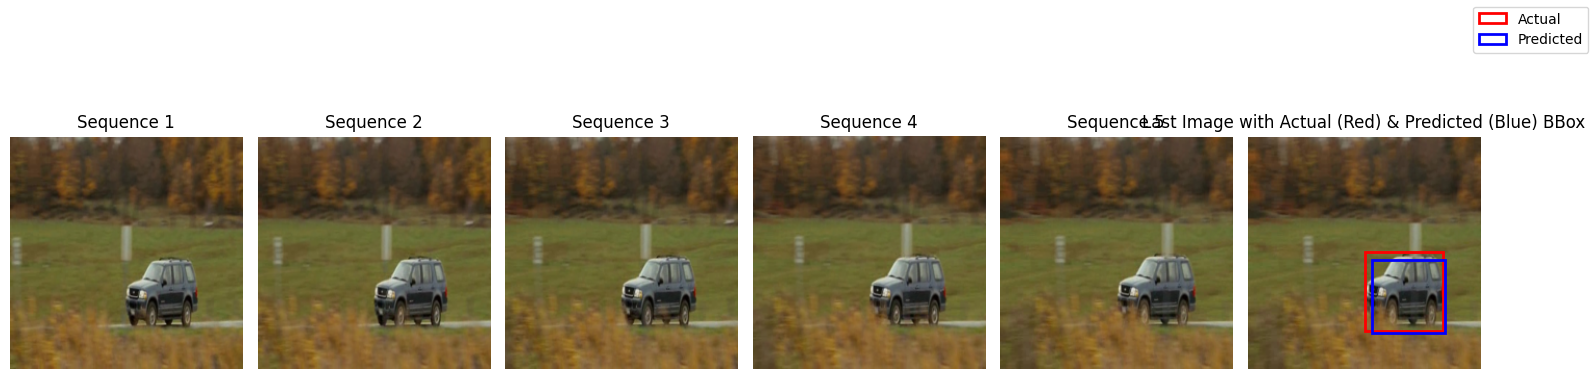

IndexError: list index out of range

In [52]:
for index in range(0,520,50):
  images, actual_bboxes = dataset[index]  # this gets the first sequence and its actual bounding boxes
  model.eval() 
  with torch.no_grad(): 

    inputs = images.unsqueeze(0).to(device)  # add batch dimension and move to device
    bboxes_input = actual_bboxes[:-1].unsqueeze(0).to(device)  #first 4 bboxes, add batch dim, move to device

    # prediction
    pred_bbox = model(inputs[:, :, :, :, :], bboxes_input)  # pass the whole sequence and bboxes to the model
    # The output, pred_bbox, is the predicted bounding box for the last image in the sequence
  plot_sequence_with_pred_and_actual_bbox(dataset, index, pred_bbox.squeeze())
